#Power method decomposition


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [ ]:
d = 10
k = 6
n = 1000
tot = k * n
s = 2
dist = 20
spher = True
cov_range = 2

In [ ]:
def generate_data():
    A = -dist+(dist+dist)*np.random.rand(d, k)
    X = np.zeros((tot, d))

    plt.axis('equal')

    for i in range(k):
        mean = np.transpose(A[:, i])
        if spher:
            covariance = s * np.identity(d)
        else:
            a = -cov_range + (cov_range + cov_range) * np.random.rand(d, d)
            covariance = np.matmul(np.transpose(a), a)
        mvn = np.random.multivariate_normal(mean, covariance, n)
        #plt.plot(mvn[:, 0], mvn[:, 1], '.')
        #plt.plot(mean[0], mean[1], 'x')
        X[i*n:(i+1)*n, :] = mvn

    return (X, A)

In [ ]:
def calculate_first_moment(X):
    mu = np.zeros((d, 1))
    for t in range(tot):
        for i in range(d):
            mu[i] += + X[t, i]
    mu /= tot
    return mu

In [ ]:
def calculate_second_moment(X):
    Sigma = np.zeros((d, d))
    for t in range(tot):
        for i in range(d):
            for j in range(d):
                Sigma[i, j] += np.dot(X[t, i],X[t, j])
    Sigma /= tot
    return Sigma

In [ ]:
def perform_whitening(X, U, S):
    W = np.matmul(U[:, 0:k], np.sqrt(np.linalg.pinv(np.diag(S[0:k]))))
    X_whit = np.matmul(X, W)
    return (W, X_whit)

In [ ]:
def extract_information_from_second_moment(Sigma, X):
    U, S, _ = np.linalg.svd(Sigma)
    s_est = S[-1]
    W, X_whit = perform_whitening(X, U, S)
    return (s_est, W, X_whit)

In [ ]:
def perform_tensor_power_method(X_whit, W, s_est, mu):
    TOL = 1e-8
    maxiter = 100
    V_est = np.zeros((k, k))
    lamb = np.zeros((k, 1))

    for i in range(k):
        v_old = np.random.rand(k, 1)
        v_old = np.divide(v_old, np.linalg.norm(v_old))
        for iter in range(maxiter):
            v_new = (np.matmul(np.transpose(X_whit), (np.matmul(X_whit, v_old) * np.matmul(X_whit, v_old)))) / tot
            #v_new = v_new - s_est * (W' * mu * dot((W*v_old),(W*v_old)));
            #v_new = v_new - s_est * (2 * W' * W * v_old * ((W'*mu)' * (v_old)));
            v_new -= s_est * (np.matmul(np.matmul(W.T, mu), np.dot(np.matmul(W, v_old).T,np.matmul(W, v_old))))
            v_new -= s_est * (2 * np.matmul(W.T, np.matmul(W, np.matmul(v_old, np.matmul(np.matmul(W.T, mu).T, v_old)))))
            if i > 0:
                for j in range(i):
                    v_new -= np.reshape(V_est[:, j] * np.power(np.matmul(np.transpose(v_old), V_est[:, j]), 2) * lamb[j], (k, 1))
            l = np.linalg.norm(v_new)
            v_new = np.divide(v_new, np.linalg.norm(v_new))
            if np.linalg.norm(v_old - v_new) < TOL:
                V_est[:, i] = np.reshape(v_new, k)
                lamb[i] = l
                break
            v_old = v_new

    return (V_est, lamb)

In [ ]:
def perform_backwards_transformation(V_est, lamb):
    return np.matmul(np.matmul(np.linalg.pinv(np.transpose(W)), V_est), np.diag(np.reshape(lamb.T, k)))

In [ ]:
def plot_results(X, A, A_est, s_est):
    plt.axis('equal')

    ax = plt.subplot(aspect='equal')

    plt.plot(X[:,0], X[:,1], '.', zorder=-3)

    for i in range(k):
        mean = A[:, i].T
        mean_est = A_est[:, i].T

        plt.plot(mean[0], mean[1], 'x', color='y', zorder=-2)
        plt.plot(mean_est[0], mean_est[1], '+', color='r', zorder=-1)

        ell = Ellipse(xy=(mean_est[0], mean_est[1]),
                      width=s_est, height=s_est,
                      angle=0, color='red')
        ell.set_facecolor('none')
        ax.add_artist(ell)

    plt.show()


<ipython-input-8-c094fd855d70>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(aspect='equal')


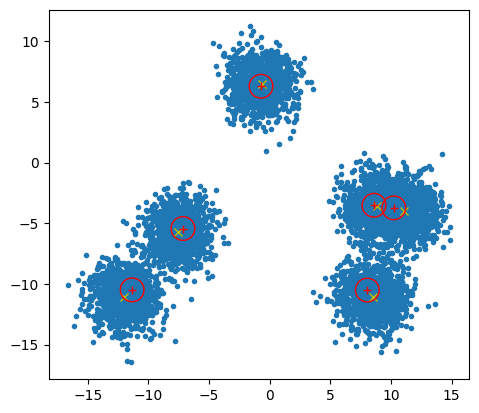

In [ ]:
X, A = generate_data()

mu = calculate_first_moment(X)
Sigma = calculate_second_moment(X)

s_est, W, X_whit = extract_information_from_second_moment(Sigma, X)

V_est, lamb = perform_tensor_power_method(X_whit, W, s_est, mu)

A_est = perform_backwards_transformation(V_est, lamb)

plot_results(X, A, A_est, s_est)

#Tucker decomposition


In [ ]:
!pip install tensorly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 16.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import tucker

# Generate a toy text corpus
corpus = ['cat dog fish', 'dog fish bird', 'bird cat', 'fish bird cat']

# Create a vocabulary of unique words
vocab = sorted(list(set(' '.join(corpus).split())))

# Create a word-document-topic tensor
X = np.zeros((len(vocab), len(corpus), 2))
for i, doc in enumerate(corpus):
    for j, word in enumerate(vocab):
        X[j, i, 0] = doc.count(word)

# Perform Tucker decomposition
core, factors = tucker(X, rank=[5, 2, 2])

# Extract the topics from the factor matrices
word_topics = factors[0].argmax(axis=1)
doc_topics = factors[1].argmax(axis=1)

# Print the top words and documents for each topic
for k in range(2):
    print(f'Topic {k}:')
    top_words = [vocab[i] for i in np.argsort(factors[0][:,k])[::-1][:3]]
    print('Top words:', ', '.join(top_words))
    top_docs = [corpus[i] for i in np.argsort(factors[1][:,k])[::-1][:3]]
    print('Top documents:', ', '.join(top_docs))
    print()

Topic 0:
Top words: fish, cat, bird
Top documents: fish bird cat, dog fish bird, cat dog fish

Topic 1:
Top words: dog, fish, bird
Top documents: bird cat, fish bird cat, dog fish bird



/usr/local/lib/python3.10/dist-packages/tensorly/tenalg/svd.py:193: UserWarning: Trying to compute SVD with n_eigenvecs=5, which is larger than max(matrix.shape)=4. Setting n_eigenvecs to 4.
  warnings.warn(
